In [1]:
# Plot Percentage Loss over Influence Index
import matplotlib.pyplot as plt
import numpy as np
from results import report

ADVERSARIAL_ATTACK = 'to_dst'
ignore_attacks = ['macro avg', 'Theft', 'Normal']
for graph_type, graph_type_data in report.items():
    temp = graph_type_data.copy().items()
    for window, window_data in temp:
        temp2 = window_data.copy().items()
        for attack, attack_data in temp2:
            if attack in ignore_attacks:
                del window_data[attack]


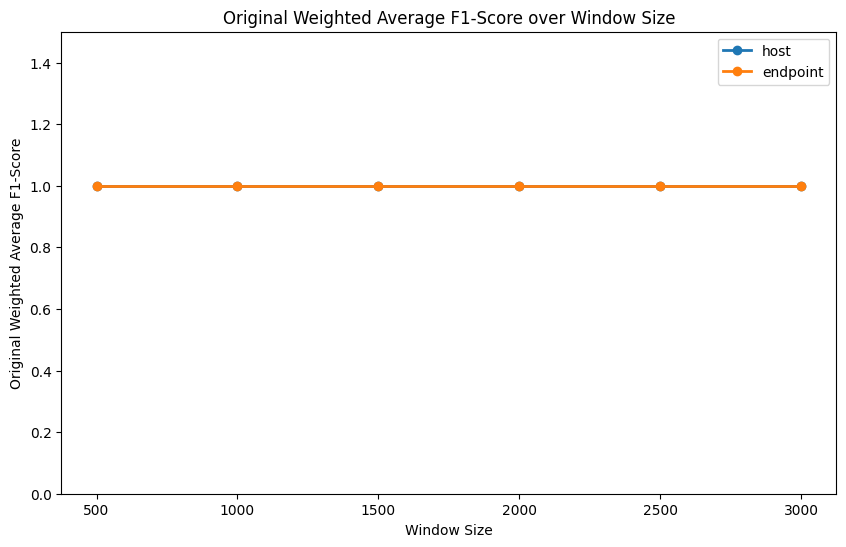

In [2]:
def plot_normal_f1_over_window(report):
    plt.figure(figsize=(10, 6))
    for graph_type, graph_type_data in report.items():
        window_sizes = []
        losses = []
        for window_size, attacks in graph_type_data.items():
            if 'Weighted Average' in attacks:
                window_sizes.append(window_size)
                class_data = attacks['Weighted Average']
                losses.append(class_data['normal_f1'])
        plt.plot(window_sizes, losses, label=graph_type, marker='o', linewidth=2)

    plt.xlabel('Window Size')
    plt.ylabel('Original Weighted Average F1-Score')
    plt.title('Original Weighted Average F1-Score over Window Size')
    plt.ylim(0, 1.5)
    plt.legend()
    plt.show()

plot_normal_f1_over_window(report)

In [3]:
def get_percentage_loss(class_data):
    """Calculate the percentage loss."""
    normal_f1 = class_data['normal_f1']
    adversarial_f1 = class_data[f'{ADVERSARIAL_ATTACK}_f1']
                
    epsilon = 1e-10  # To avoid division by zero
    return (normal_f1 - adversarial_f1) / (normal_f1 + epsilon) * 100

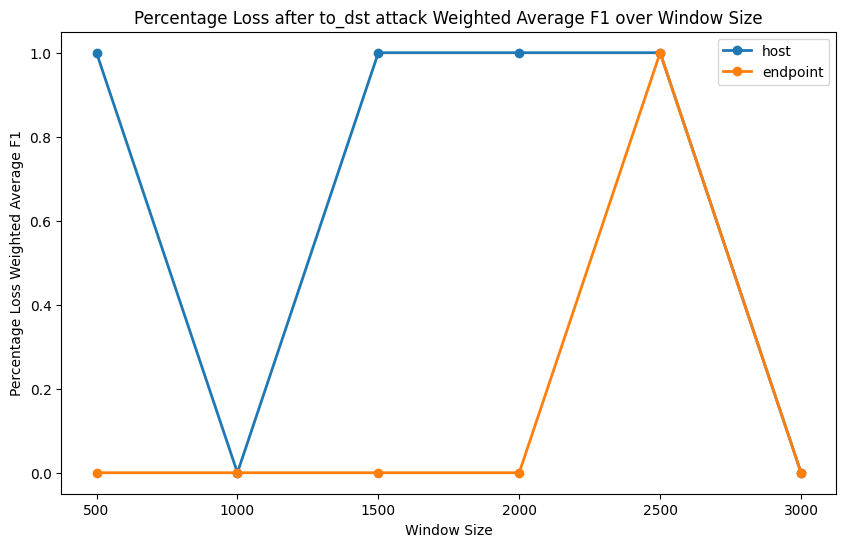

In [4]:
def plot_weighted_average_over_window(report):
    plt.figure(figsize=(10, 6))
    for graph_type, graph_type_data in report.items():
        window_sizes = []
        losses = []
        for window_size, attacks in graph_type_data.items():
            if 'Weighted Average' in attacks:
                window_sizes.append(window_size)
                class_data = attacks['Weighted Average']
                losses.append(get_percentage_loss(class_data))
        plt.plot(window_sizes, losses, label=graph_type, marker='o', linewidth=2)

    plt.xlabel('Window Size')
    plt.ylabel('Percentage Loss Weighted Average F1')
    plt.title(f'Percentage Loss after {ADVERSARIAL_ATTACK} attack Weighted Average F1 over Window Size')
    plt.legend()
    plt.show()

plot_weighted_average_over_window(report)

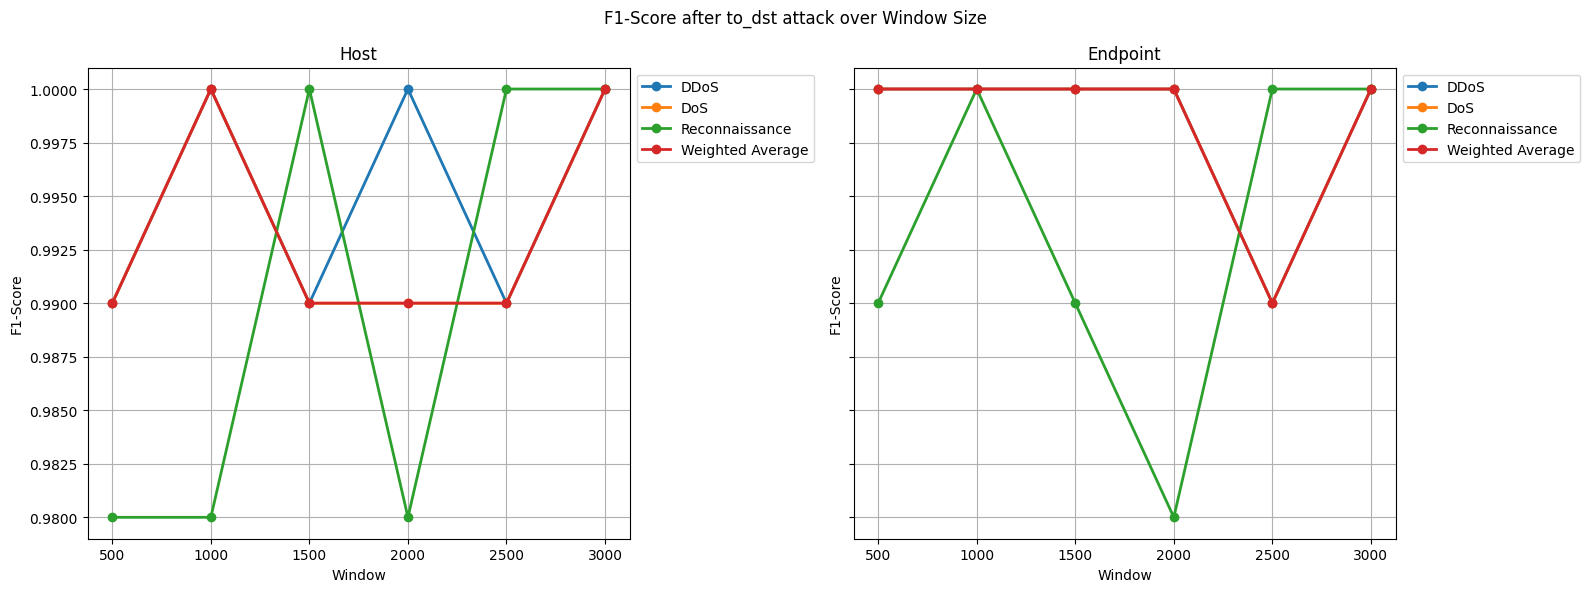

In [5]:
def plot_f1_over_window(report):
    fig, axes = plt.subplots(1, len(report), figsize=(16, 6), sharey=True)

    if len(report) == 1:
        axes = [axes]

    for ax, (host_type, data) in zip(axes, report.items()):
        # Prepare data grouped by attack_name
        grouped_data = {}
        for window_size, attacks in data.items():
            for attack_name, attack_data in attacks.items():
                adversarial_f1 = attack_data[f"{ADVERSARIAL_ATTACK}_f1"]
                if attack_name not in grouped_data:
                    grouped_data[attack_name] = {"window_size": [], f"{ADVERSARIAL_ATTACK}_f1": []}
                grouped_data[attack_name]["window_size"].append(window_size)
                grouped_data[attack_name][f"{ADVERSARIAL_ATTACK}_f1"].append(adversarial_f1)

        # Plot grouped data
        for attack_name, vals in grouped_data.items():
            ax.plot(vals["window_size"], vals[f"{ADVERSARIAL_ATTACK}_f1"], label=attack_name, marker='o', linewidth=2)

        ax.set_title(f'{host_type.capitalize()}')
        ax.set_xlabel('Window')
        ax.set_ylabel('F1-Score')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    fig.suptitle(f'F1-Score after {ADVERSARIAL_ATTACK} attack over Window Size')
    plt.tight_layout()
    plt.show()

plot_f1_over_window(report)

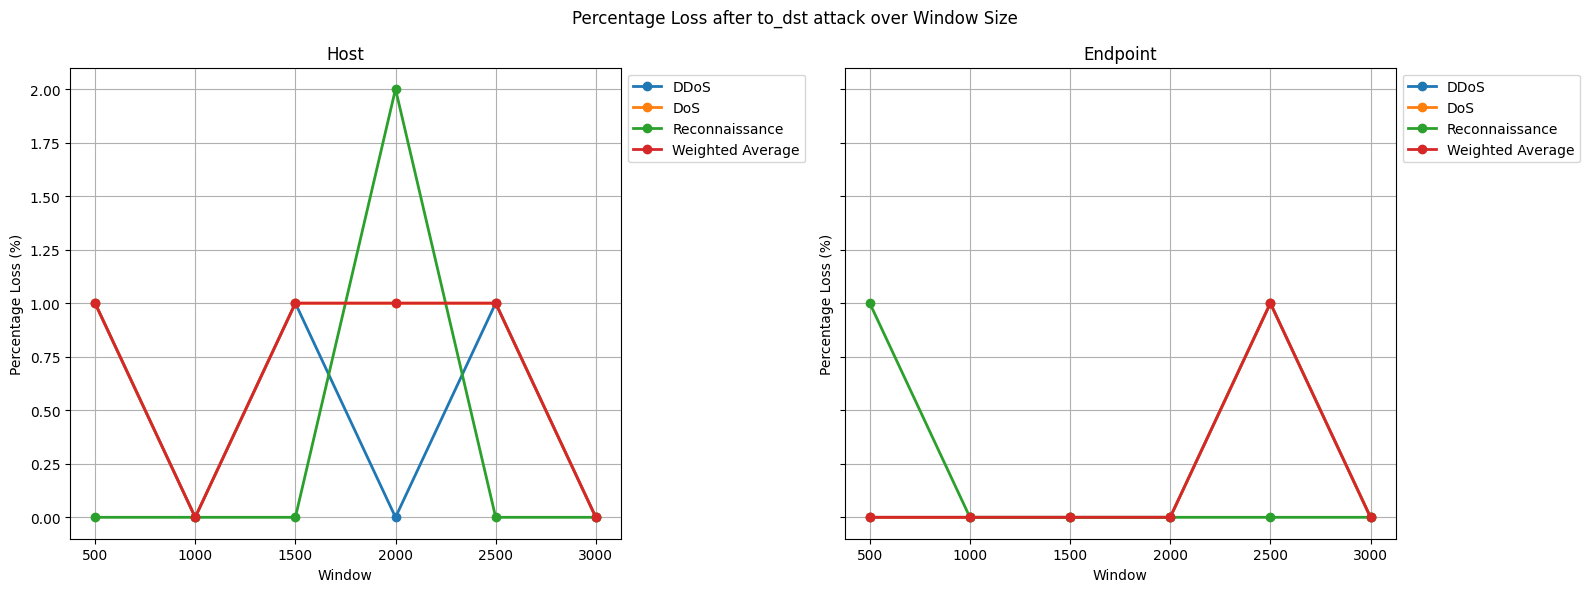

In [6]:
def plot_percentage_loss_over_window(report):
    fig, axes = plt.subplots(1, len(report), figsize=(16, 6), sharey=True)

    if len(report) == 1:
        axes = [axes]

    for ax, (host_type, data) in zip(axes, report.items()):
        # Prepare data grouped by attack_name
        grouped_data = {}
        for window_size, attacks in data.items():
            for attack_name, attack_data in attacks.items():
                
                adversarial_percentage_loss = get_percentage_loss(attack_data)
                if attack_name not in grouped_data:
                    grouped_data[attack_name] = {"window_size": [], f"{ADVERSARIAL_ATTACK}_percentage_loss": []}
                grouped_data[attack_name]["window_size"].append(window_size)
                grouped_data[attack_name][f"{ADVERSARIAL_ATTACK}_percentage_loss"].append(adversarial_percentage_loss)

        # Plot grouped data
        for attack_name, vals in grouped_data.items():
            ax.plot(vals["window_size"], vals[f"{ADVERSARIAL_ATTACK}_percentage_loss"], label=attack_name, marker='o', linewidth=2)

        ax.set_title(f'{host_type.capitalize()}')
        ax.set_xlabel('Window')
        ax.set_ylabel('Percentage Loss (%)')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    fig.suptitle(f'Percentage Loss after {ADVERSARIAL_ATTACK} attack over Window Size')
    plt.tight_layout()
    plt.show()

plot_percentage_loss_over_window(report)

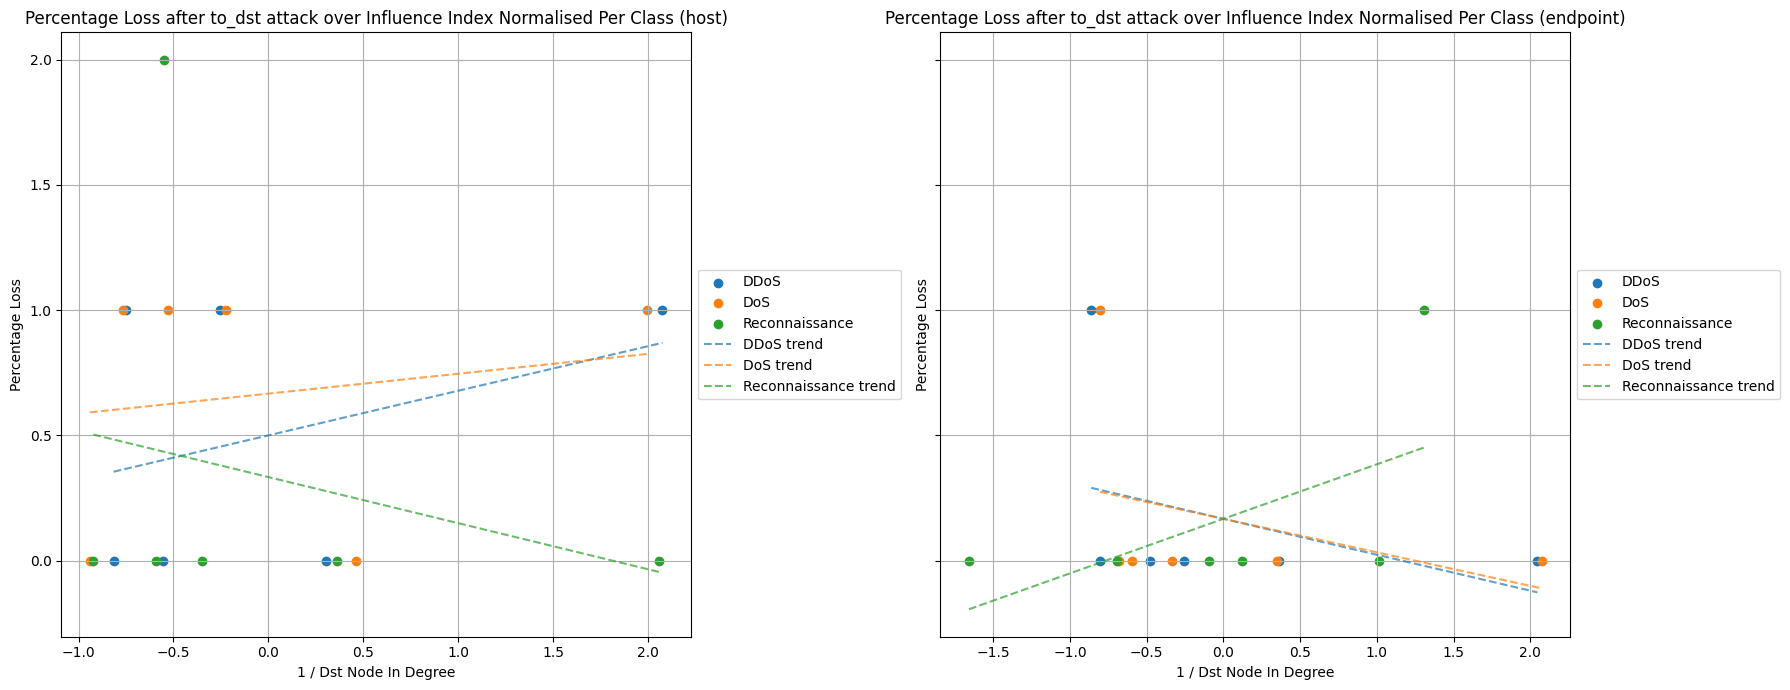

In [7]:
def plot_percentage_loss_over_influence(report):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    graph_ids = ['host', 'endpoint']

    for ax, graph_id in zip(axes, graph_ids):
        color_map = {}
        color_cycle = plt.cm.tab10.colors
        class_names = set()
        for window_data in report[graph_id].values():
            class_names.update(window_data.keys())
        for idx, class_name in enumerate(sorted(class_names)):
            color_map[class_name] = color_cycle[idx % len(color_cycle)]

        influence_indices = []
        percentage_losses = []
        class_points = {}

        for window, window_data in report[graph_id].items():
            for class_name, data in window_data.items():
                if class_name == 'Weighted Average' or class_name == 'Macro Average':
                    continue
                min_out_degree, avg_out_degree, max_out_degree = data['out_degree']
                min_in_degree, avg_in_degree, max_in_degree = data['in_degree']
                epsilon = 1e-10  # To avoid division by zero
                max_ratio = max_out_degree / (min_in_degree + epsilon)  # Avoid division by zero
                min_ratio = min_out_degree / (max_in_degree + epsilon)  # Avoid division by zero
                avg_ratio = avg_out_degree / (avg_in_degree + epsilon)
                avg_index = 1 / avg_in_degree

                percentage_loss = get_percentage_loss(data)
                influence_indices.append(avg_index)
                percentage_losses.append(percentage_loss)
                if class_name not in class_points:
                    class_points[class_name] = {"x": [], "y": [], "window": []}
                class_points[class_name]["x"].append(avg_index)
                class_points[class_name]["y"].append(percentage_loss)
                class_points[class_name]["window"].append(window)
        for class_name, points in class_points.items():
            ax.scatter((points["x"] - np.mean(points["x"])) / np.std(points['x']), points["y"], color=color_map[class_name], label=class_name, alpha=1)
            # ax.plot(
            #     [avg_index], 
            #     [percentage_loss], 
            #     marker='o', 
            #     label=f'{class_name}', 
            #     linewidth=2,
            #     color=color_map[class_name]
            # )
            # ax.text(
            #     avg_index, 
            #     percentage_loss, 
            #     f'{avg_index:.2f}',
            #     fontsize=8, 
            #     ha='right', 
            #     va='bottom', 
            #     color=color_map[class_name]
            # )

        for class_name, points in class_points.items():
            if len(points["x"]) > 1:
                z = np.polyfit((points["x"] - np.mean(points["x"])) / np.std(points['x']), points["y"], 1)
                p = np.poly1d(z)
                x_vals = np.linspace(min((points["x"] - np.mean(points["x"])) / np.std(points['x'])), max((points["x"] - np.mean(points["x"])) / np.std(points['x'])), 100)
                ax.plot(x_vals, p(x_vals), "--", color=color_map[class_name], alpha=0.7, label=f"{class_name} trend")

        ax.set_xlabel('1 / Dst Node In Degree')
        ax.set_ylabel('Percentage Loss')
        ax.set_title(f'Percentage Loss after {ADVERSARIAL_ATTACK} attack over Influence Index Normalised Per Class ({graph_id})')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_percentage_loss_over_influence(report)
